In [1]:
# import the necessary packages
from sklearn.cluster import AgglomerativeClustering
from pytesseract import Output
import pandas as pd
import numpy as np
import pytesseract
import imutils
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [139]:
# set a seed for our random number generator
np.random.seed(42)

# load the input image and convert it to grayscale
image = cv2.imread('data-ocr/20f66705-c840-44b2-ad04-895490009eb0.JPG')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

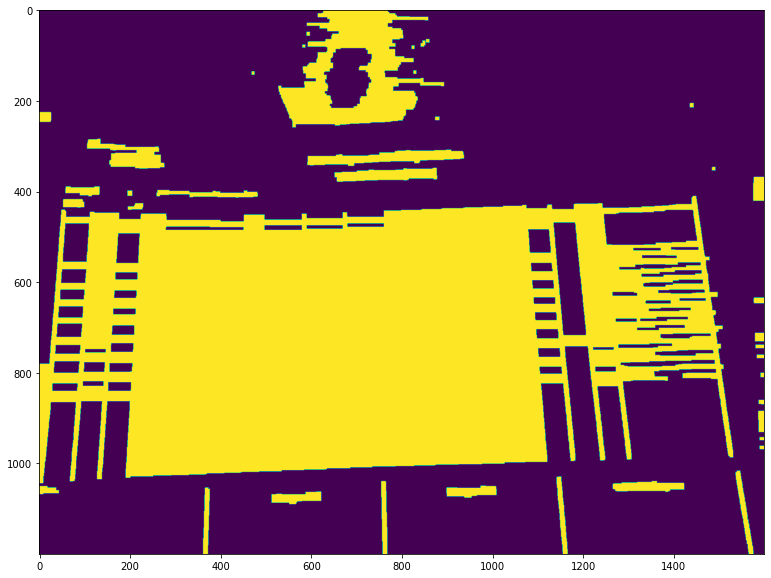

In [140]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morphological operator to find dark regions on a light
# background
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

# compute the Scharr gradient of the blackhat image and scale the
# result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")

# apply a closing operation using the rectangular kernel to close
# gaps in between characters, apply Otsu's thresholding method, and
# finally a dilation operation to enlarge foreground regions
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255,
                       cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)
plt.figure(figsize = (20, 10))
plt.imshow(thresh)

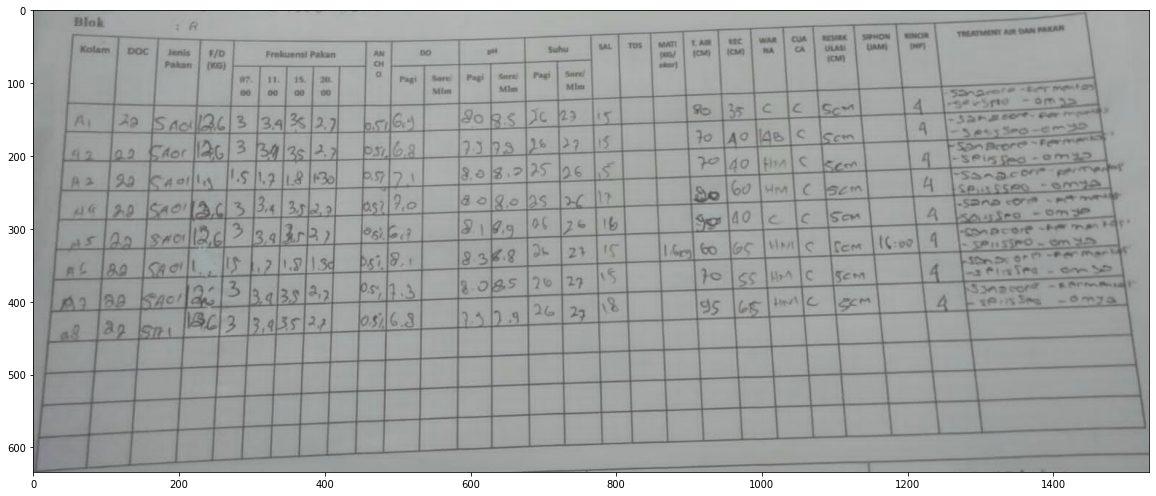

In [141]:
# find contours in the thresholded image and grab the largest one,
# which we will assume is the stats table
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

tableCnt = max(cnts, key=cv2.contourArea)

# compute the bounding box coordinates of the stats table and extract
# the table from the input image

(x, y, w, h) = cv2.boundingRect(tableCnt)
table = image[y:y + h, x:x + w]

plt.figure(figsize = (20, 10))
plt.imshow(table)

In [142]:
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
# set the PSM mode to detect sparse text, and then localize text in
# the table
options = "--psm 11"
results = pytesseract.image_to_data(
    cv2.cvtColor(table, cv2.COLOR_BGR2RGB),
    config=options,
    output_type=Output.DICT)
# initialize a list to store the (x, y)-coordinates of the detected
# text along with the OCR'd text itself
coords = []
ocrText = []

In [143]:
# loop over each of the individual text localizations
for i in range(0, len(results["text"])):
    # extract the bounding box coordinates of the text region from
    # the current result
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
    # extract the OCR text itself along with the confidence of the
    # text localization
    text = results["text"][i]
    conf = int(results["conf"][i])
    # filter out weak confidence text localizations
    if conf > 0:
        # update our text bounding box coordinates and OCR'd text,
        # respectively
        coords.append((x, y, w, h))
        ocrText.append(text)

In [144]:
# extract all x-coordinates from the text bounding boxes, setting the
# y-coordinate value to zero
xCoords = [(c[0], 0) for c in coords]
# apply hierarchical agglomerative clustering to the coordinates
clustering = AgglomerativeClustering(
    n_clusters=None,
    affinity="manhattan",
    linkage="complete",
    distance_threshold=10)
clustering.fit(xCoords)
# initialize our list of sorted clusters
sortedClusters = []

In [145]:
# loop over all clusters
for l in np.unique(clustering.labels_):
    # extract the indexes for the coordinates belonging to the
    # current cluster
    idxs = np.where(clustering.labels_ == l)[0]
    # verify that the cluster is sufficiently large
    if len(idxs) > 2:
        # compute the average x-coordinate value of the cluster and
        # update our clusters list with the current label and the
        # average x-coordinate
        avg = np.average([coords[i][0] for i in idxs])
        sortedClusters.append((l, avg))
# sort the clusters by their average x-coordinate and initialize our
# data frame
sortedClusters.sort(key=lambda x: x[1])
df = pd.DataFrame()

In [146]:
# loop over the clusters again, this time in sorted order
for (l, _) in sortedClusters:
    # extract the indexes for the coordinates belonging to the
    # current cluster
    idxs = np.where(clustering.labels_ == l)[0]
    # extract the y-coordinates from the elements in the current
    # cluster, then sort them from top-to-bottom
    yCoords = [coords[i][1] for i in idxs]
    sortedIdxs = idxs[np.argsort(yCoords)]
    # generate a random color for the cluster
    color = np.random.randint(0, 255, size=(3,), dtype="int")
    color = [int(c) for c in color]
    # loop over the sorted indexes
    
    for i in sortedIdxs:
        # extract the text bounding box coordinates and draw the
        # bounding box surrounding the current element
        (x, y, w, h) = coords[i]
        cv2.rectangle(table, (x, y), (x + w, y + h), color, 2)
        # extract the OCR'd text for the current column, then construct
        # a data frame for the data where the first entry in our column
        # serves as the header
    cols = [ocrText[i].strip() for i in sortedIdxs]
    currentDF = pd.DataFrame({cols[0]: cols[1:]})
    # concatenate *original* data frame with the *current* data
    # frame (we do this to handle columns that may have a varying
    # number of rows)
    df = pd.concat([df, currentDF], axis=1)

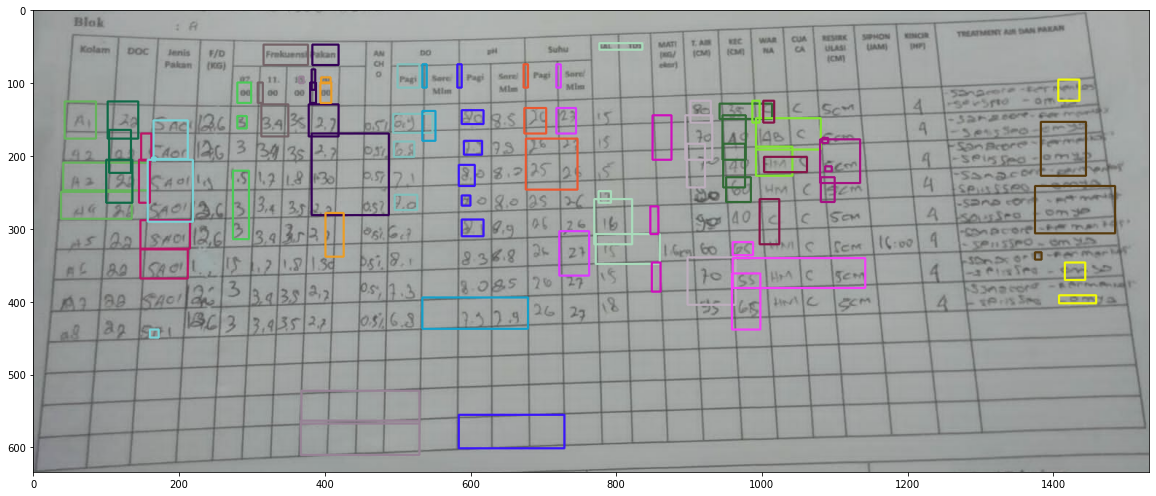

In [147]:
# replace NaN values with an empty string and then show a nicely
# formatted version of our multi-column OCR'd text
df.fillna("", inplace=True)
plt.figure(figsize = (20, 10))
plt.imshow(table)